# Chapter 19 How to Develop CNNs for Multi-step Energy Usage Forecasting

In this tutorial, you will discover how to develop 1D convolutional neural networks for multi-step time series forecasting. After completing this tutorial, you will know:
- How to develop a CNN for multi-step time series forecasting model for univariate data.
- How to develop a multi-channel multi-step time series forecasting model for multivariate
data.
- How to develop a multi-headed multi-step time series forecasting model for multivariate data.

## 19.1 Tutorial Overview
This tutorial is divided into seven parts; they are: 
1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. CNNs for Multi-step Forecasting 
5. Univariate CNN Model
6. Multi-channel CNN Model
7. Multi-headed CNN Model

## 19.2 Problem Description

It is a multivariate series comprised of seven variables
(besides the date and time); they are:
- global active power: The total active power consumed by the household (kilowatts).
- global reactive power: The total reactive power consumed by the household (kilowatts). 􏰀 voltage: Average voltage (volts).
- global intensity: Average current intensity (amps).
- sub metering 1: Active energy for kitchen (watt-hours of active energy).
- sub metering 2: Active energy for laundry (watt-hours of active energy).
- sub metering 3: Active energy for climate control systems (watt-hours of active energy).

## 19.3 Load and Prepare Dataset

## 19.4 Model Evaluation

### 19.4.1 Walk-Forward Validation

The walk-forward validation approach to evaluating predictive models on this dataset is provided below, named evaluate_model().

The train and test datasets in standard-week format are provided to the function as arguments. 

An additional argument, n input, is provided that is used to define the number of prior observations that the model will use as input in order to make a prediction. 

Two new functions are called: one to build a model from the training data called build model() and another that uses the model to make forecasts for each new standard week, called forecast(). 

These will be covered in subsequent sections.

In [1]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [2]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

## 19.5 CNNs for Multi-step Forecasting

CNNs can be used in either a recursive or direct forecast strategy, where the model makes one-step predictions and outputs are fed as inputs for subsequent predictions, and where one model is developed for each time step to be predicted. Alternately, CNNs can be used to predict the entire output sequence as a one-step prediction of the entire vector. This is a general benefit of feedforward neural networks.

CNN 可用于递归或直接预测策略，其中模型进行一步预测，输出作为后续预测的输入，并且为每个要预测的时间步开发一个模型。或者，CNN可用于预测整个输出序列，作为对整个矢量的一步预测。这是前馈神经网络的一般好处。

An important secondary benefit of using CNNs is that they can support multiple 1D inputs in order to make a prediction. This is useful if the multi-step output sequence is a function of more than one input sequence. This can be achieved using two different model configurations.
- Multiple Input Channels. This is where each input sequence is read as a separate channel, like the different channels of an image (e.g. red, green and blue).
- Multiple Input Heads. This is where each input sequence is read by a different CNN submodel and the internal representations are combined before being interpreted and used to make a prediction.

使用 CNN 的一个重要次要好处是它们可以支持多个 1D 输入以进行预测。如果多步输出序列是多个输入序列的函数，则此功能非常有用。这可以使用两种不同的模型配置来实现。
- 多个输入通道。这是每个输入序列作为单独通道读取的地方，就像图像的不同通道（例如红色、绿色和蓝色）一样。
- 多个输入头。这是每个输入序列由不同的CNN子模型读取的地方，并且在解释和用于预测之前将内部表示组合在一起。

In this tutorial, we will explore how to develop three different types of CNN models for multi-step time series forecasting; they are:
- A CNN for **multi-step** time series forecasting with **univariate** input data.
- A CNN for **multi-step** time series forecasting with **multivariate** input data via **channels**. 
- A CNN for **multi-step** time series forecasting with **multivariate** input data via **submodels**.

## 19.6 Univariate CNN Model

**Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption.**

|Input,| Output|
|:---|:---|
|[d01, d02, d03, d04, d05, d06, d07],| [d08, d09, d10, d11, d12, d13, d14] |
|[d02, d03, d04, d05, d06, d07, d08],| [d09, d10, d11, d12, d13, d14, d15] |
|...|

Below is a function named to_supervised() that takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [4]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

When we run this function on the entire training dataset, we transform 159 samples into 1,100; specifically, the transformed dataset has the shapes X=[1100, 7, 1] and y=[1100, 7].

In [6]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # define model
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

**The complete example is listed below.**


to_supervised:train_shape:  159 7 8 7
to_supervised:shape of data: (1113, 8)
to_supervised: (1100, 7, 1) (1100, 7)
shape of train_x: (1100, 7, 1)
build_model: 7 1 7
build_model:(input_shape): 7 1
cnn: [417.138] 450.7, 403.9, 358.6, 407.0, 412.6, 322.9, 532.0


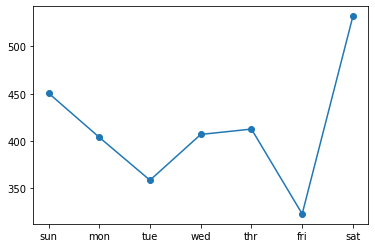

In [23]:
# univariate multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

# 滑动窗口个数为：length-窗口长度+1（1113-(7 input + 7 output)+1）
def to_supervised(train, n_input, n_out=7):
    # flatten data
    print('to_supervised:train_shape: ',train.shape[0], train.shape[1], train.shape[2],n_input)
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    print("to_supervised:shape of data:",np.shape(data))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
#         print("in_end",in_end)
#         print("out_end",out_end)
        # ensure we have enough data for this instance
        if out_end <= len(data):
            # 注意此处只使用了data的第0个参数
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    print('to_supervised:',np.shape(X),np.shape(y))
    return array(X), array(y)
    
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    print("shape of train_x:",np.shape(train_x))
    # define parameters
    verbose, epochs, batch_size = 0, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # define model
    print("build_model:", n_timesteps, n_features, n_outputs)
    print("build_model:(input_shape):", n_timesteps,n_features)
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 7
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('cnn', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='cnn') 
    pyplot.show()

In [12]:
import numpy as np
print(np.shape(train))
print(np.shape(test))

(159, 7, 8)
(46, 7, 8)


**We can increase the number of prior days to use as input from seven to 14 by changing the
n input variable.**


to_supervised:train_shape:  159 7 8 14
to_supervised:shape of data: (1113, 8)
to_supervised: (1093, 14, 1) (1093, 7)
shape of train_x: (1093, 14, 1)
build_model: 14 1 7
build_model:(input_shape): 14 1
cnn: [392.819] 392.5, 406.9, 356.1, 423.9, 375.9, 329.4, 451.9


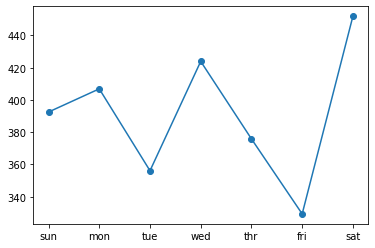

In [24]:
# univariate multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

# 滑动窗口个数为：length-窗口长度+1（1113-(7 input + 7 output)+1）
def to_supervised(train, n_input, n_out=7):
    # flatten data
    print('to_supervised:train_shape: ',train.shape[0], train.shape[1], train.shape[2],n_input)
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    print("to_supervised:shape of data:",np.shape(data))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
#         print("in_end",in_end)
#         print("out_end",out_end)
        # ensure we have enough data for this instance
        if out_end <= len(data):
            # 注意此处只使用了data的第0个参数
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    print('to_supervised:',np.shape(X),np.shape(y))
    return array(X), array(y)
    
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    print("shape of train_x:",np.shape(train_x))
    # define parameters
    verbose, epochs, batch_size = 0, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # define model
    print("build_model:", n_timesteps, n_features, n_outputs)
    print("build_model:(input_shape):", n_timesteps,n_features)
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('cnn', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='cnn') 
    pyplot.show()

## 19.7 Multi-channel CNN Model

使用前一周的8个参数数据预测接下来一周的变量0.

We now have all of the elements required to develop a multi-channel CNN for multivariate input data to make multi-step time series forecasts. The complete example is listed below.

cnn: [402.321] 434.8, 375.3, 361.7, 409.4, 341.9, 317.7, 535.6


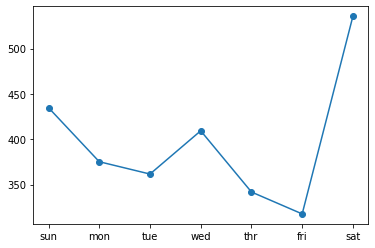

In [27]:
# multichannel multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

# 滑动窗口个数为：length-窗口长度+1（1113-(7 input + 7 output)+1）
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)
    
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # define model
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('cnn', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='cnn') 
    pyplot.show()

## 19.8 Multi-headed CNN Model

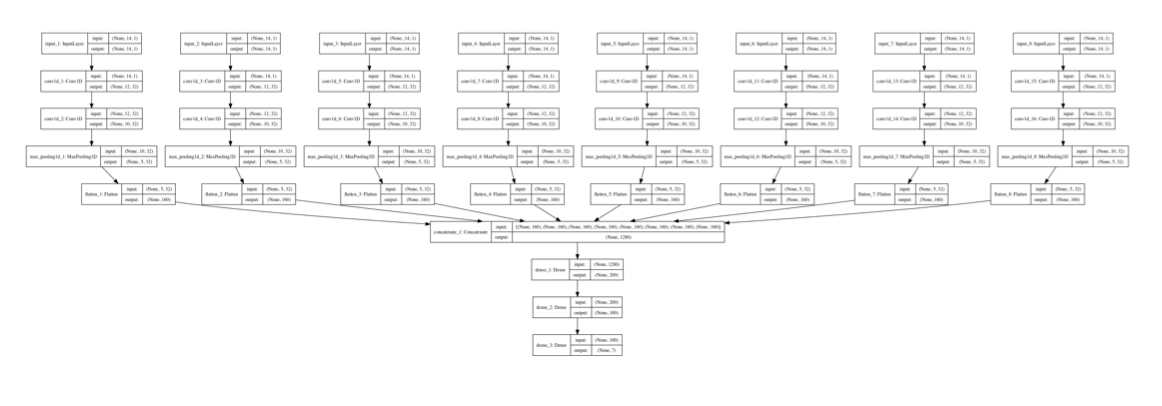

cnn: [406.184] 436.6, 465.7, 336.0, 408.9, 378.3, 353.3, 446.6


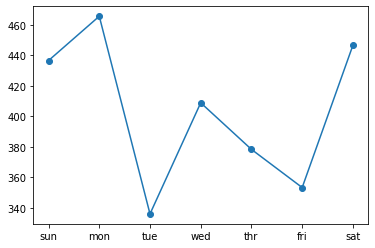

In [31]:
# multi headed multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

# 滑动窗口个数为：length-窗口长度+1（1113-(7 input + 7 output)+1）
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# plot training history
def plot_history(history):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(history.history['loss'], label='train') 
    pyplot.plot(history.history['val_loss'], label='test') 
    pyplot.title('loss', y=0, loc='center') 
    pyplot.legend()
    # plot rmse
    pyplot.subplot(2, 1, 2) 
    pyplot.plot(history.history['rmse'], label='train') 
    pyplot.plot(history.history['val_rmse'], label='test') 
    pyplot.title('rmse', y=0, loc='center') 
    pyplot.legend()
    pyplot.show()

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for i in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(32, 3, activation='relu')(inputs) 
        conv2 = Conv1D(32, 3, activation='relu')(conv1) 
        pool1 = MaxPooling1D()(conv2)
        flat = Flatten()(pool1)
        # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense1 = Dense(200, activation='relu')(merged)
    dense2 = Dense(100, activation='relu')(dense1) 
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs) # compile model
    model.compile(loss='mse', optimizer='adam')
    # plot the model
    #plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in
      range(n_features)]
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0,infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime']) 
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('cnn', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='cnn') 
    pyplot.show()

## 19.9 Extensions
This section lists some ideas for extending the tutorial that you may wish to explore.
- Size of Input. Explore more or fewer numbers of days used as input for the model, such as three days, 21 days, 30 days and more.
- Model Tuning. Tune the structure and hyperparameters for a model and further lift model performance on average.
- Data Scaling. Explore whether data scaling, such as standardization and normalization, can be used to improve the performance of any of the CNN models.
- Learning Diagnostics. Use diagnostics such as learning curves for the train and valida- tion loss and mean squared error to help tune the structure and hyperparameters of a CNN model.
- Vary Kernel Size. Combine the multi-channel CNN with the multi-headed CNN and use a different kernel size for each head to see if this configuration can further improve performance.

## 19.11 Summary
In this tutorial, you discovered how to develop 1D convolutional neural networks for multi-step time series forecasting. Specifically, you learned:
- How to develop a CNN for multi-step time series forecasting model for univariate data.
- How to develop a multi-channel multi-step time series forecasting model for multivariate
data.
- How to develop a multi-headed multi-step time series forecasting model for multivariate data.